## VAE-CTGAN 생성 데이터 Evaluation

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [31]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [ ]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

## Load original data
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTAB-GAN/Fake_Datasets/portfolios_newrounding.csv"
fake = pd.read_csv(fake_path, low_memory=False)

In [33]:
fake['loan_amnt'].value_counts()

loan_amnt
1000.0     8843
10025.0    5951
10000.0    5802
10050.0    5093
9975.0     4860
           ... 
39850.0      15
39450.0      14
39750.0      13
39875.0      10
39975.0       7
Name: count, Length: 1483, dtype: int64

In [34]:
for col in data.columns:
    print(f"{col} feature\n{data[col].unique()}")

last_fico_range_high feature
[744. 739. 614. 604. 654. 804. 824. 659. 559. 724. 769. 589. 499. 694.
 584. 719. 689. 669. 779. 684. 674. 749. 649. 664. 734. 639. 634. 594.
 619. 544. 699. 679. 759. 729. 784. 709. 549. 629. 704. 564. 579. 529.
 569. 714. 754. 599. 764. 539. 574. 534. 519. 524. 644. 814. 609. 794.
 789. 829. 774. 799. 514. 819. 834. 509. 624. 839. 554. 809. 504. 844.
 850.   0.]
annual_inc feature
[50000.  60000.  75000.  ... 31235.  75388.  13235.5]
dti feature
[  4.66  16.14  24.67 ...  97.94  56.6  131.58]
mo_sin_old_rev_tl_op feature
[126.         151.         292.         206.         424.
 114.         308.         131.         275.         315.
 150.         365.         105.         333.         161.
 157.          95.         321.          81.         135.
 130.         117.         102.         223.         503.
 178.          56.         103.         199.         137.
 123.         138.          29.         189.         187.
  30.         118.         186.     

In [35]:
for col in fake.columns:
    print(f"{col} feature\n{fake[col].unique()}")

last_fico_range_high feature
[599 499 539 554 574 509 629 549 639 699 559 534 739 504 584 564 544 514
 619 609 659 579 614 604 689 679 714 624 664 669 694 589 594 644 654 569
 634 519 674 649 684 524 729 709 749 744 529 769 804 719 704 784 734 754
 724 779 809 834 764 799 794 759 774 844 850 819 789 839 814 829 824]
annual_inc feature
[159996.  90318.  60578. ... 180210.  22354.  13404.]
dti feature
[23.16 35.4  27.41 ... 74.02 52.39 74.53]
mo_sin_old_rev_tl_op feature
[170.33870329 168.14147223 265.95326085 ... 311.65625524 159.93001943
 190.25740871]
revol_util feature
[0.531 0.655 0.703 ... 1.138 1.29  1.106]
int_rate feature
[0.1398 0.0988 0.1726 0.2099 0.1304 0.1323 0.1997 0.2624 0.1268 0.2197
 0.152  0.1353 0.1375 0.1403 0.1253 0.2578 0.3017 0.0726 0.162  0.2996
 0.25   0.098  0.1259 0.143  0.1333 0.1939 0.1347 0.1875 0.1776 0.0899
 0.1913 0.0818 0.1229 0.0993 0.1172 0.1595 0.0975 0.1355 0.1279 0.1387
 0.1392 0.0838 0.0649 0.0746 0.1163 0.1442 0.1645 0.1292 0.231  0.1727
 0.1064 

In [36]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
data_classification = data.copy()
test_classification = test_data.copy()
fake_classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_classification = fake_classification.drop(columns = keep_features)

In [8]:
data_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [9]:
fake_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [37]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [38]:
##Fake data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    fake_classification[col] = le.transform(fake_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(fake_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=fake_classification.index
)

# Merge
fake_classification.drop(columns=onehot_features, inplace=True)
fake_classification = pd.concat([fake_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", fake_classification.shape)

##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (540000, 35)
✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [39]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_classification = pd.concat([X_train, y_train], axis=1)

In [40]:
from sklearn.utils import shuffle

train_data = pd.concat([train_classification, fake_classification])
train_data['loan_status'].value_counts()
train_data = shuffle(train_data, random_state=42)

In [14]:
train_data['loan_status'].value_counts()

loan_status
0    718935
1    714231
Name: count, dtype: int64

In [41]:
X_train = train_data.drop(columns='loan_status')
y_train = train_data[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

model = XGBClassifier( 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68653	validation_1-logloss:0.68458
[1]	validation_0-logloss:0.68005	validation_1-logloss:0.67815
[2]	validation_0-logloss:0.67370	validation_1-logloss:0.67184
[3]	validation_0-logloss:0.66747	validation_1-logloss:0.66565
[4]	validation_0-logloss:0.66136	validation_1-logloss:0.65959
[5]	validation_0-logloss:0.65537	validation_1-logloss:0.65365
[6]	validation_0-logloss:0.64950	validation_1-logloss:0.64782
[7]	validation_0-logloss:0.64373	validation_1-logloss:0.64210
[8]	validation_0-logloss:0.63807	validation_1-logloss:0.63649
[9]	validation_0-logloss:0.63252	validation_1-logloss:0.63099
[10]	validation_0-logloss:0.62707	validation_1-logloss:0.62559
[11]	validation_0-logloss:0.62172	validation_1-logloss:0.62030
[12]	validation_0-logloss:0.61646	validation_1-logloss:0.61509
[13]	validation_0-logloss:0.61131	validation_1-logloss:0.60999
[14]	validation_0-logloss:0.60623	validation_1-logloss:0.60497
[15]	validation_0-logloss:0.60126	validation_1-logloss:0.60005
[1

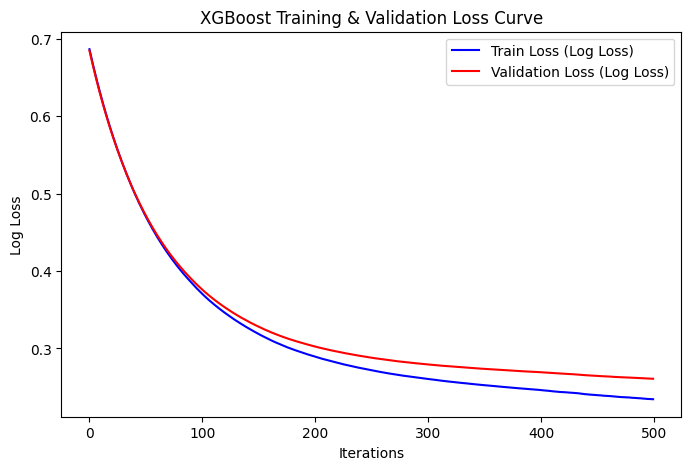

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93    599114
           1       0.65      0.90      0.75    145192

    accuracy                           0.89    744306
   macro avg       0.81      0.89      0.84    744306
weighted avg       0.91      0.89      0.89    744306



In [43]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [44]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[528189  70925]
 [ 14370 130822]]

True Positives (TP): 130822
False Positives (FP): 70925
True Negatives (TN): 528189
False Negatives (FN): 14370


## VAE-CTGAN 생성 데이터 Portfolio

In [45]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [46]:
summary_with_sharpe = []

def linear_portfolio(top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [21]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [47]:
#from sklearn.linear_model import HuberRegressor

drop2 = ['loan_status', 'return']

scaler = StandardScaler()
reg = LinearRegression()
#reg = HuberRegressor()

fully_paid_indices = (y_pred == 0)
test_regression = test_data[fully_paid_indices]
test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/(test_regression['funded_amnt']+1e-8)

train_regression = data.copy()
train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt','funded_amnt','grade','loan_amnt']
train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

fake_regression = fake.copy()
fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
fake_regression = fake_regression.drop(columns=drop_features)

train_total_reg = pd.concat([train_regression, fake_regression])

########## Encoding categorical data ######################
train_total_reg = encode_features(train_total_reg, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

data_x_reg = train_total_reg.drop(columns='return')
data_y_reg = train_total_reg[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

data_x_reg_scaled = scaler.fit_transform(data_x_reg)

X_train_reg = data_x_reg_scaled
y_train_reg = data_y_reg

test_x_scaled = scaler.transform(test_x)

reg.fit(X_train_reg, y_train_reg)

#print(reg.coef_)
y_pred_reg = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred_reg, squared=False))
print("R²:", r2_score(test_y, y_pred_reg))

test_regression['predicted_return'] = reg.predict(test_x_scaled)
top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

linear_portfolio(top_10_percent)

RMSE: 0.18588419420666888
R²: -0.33256394800113687


In [48]:
returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

returns_with_sharpe_df.head()

,Average Return,Std Dev,Sharpe Ratio
0,15.686092,0.123757,1.267495


## Analysis between Original and VAE-TableGAN Samples

In [49]:
label1_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category_1.csv"
label1_data = pd.read_csv(label1_data_path, low_memory=False)

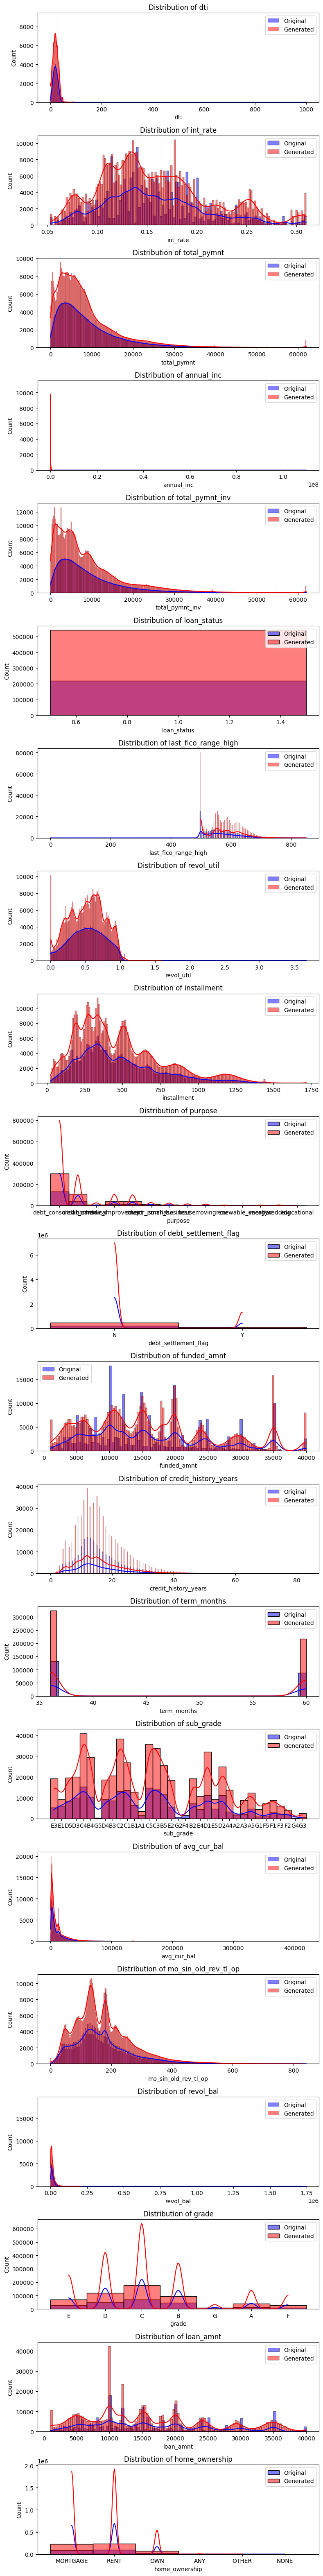

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 원본 데이터와 TableGAN 생성 데이터 불러오기
# 원본 데이터: original_df
# TableGAN이 생성한 데이터: generated_df

# 공통 feature 선택 (혹시 컬럼이 다를 수도 있으니)
common_features = list(set(data.columns) & set(fake.columns))
original_df = label1_data[common_features]
generated_df = fake[common_features]

# ------------------------------
# 1️⃣ 히스토그램 비교 (각 feature 분포)
# ------------------------------
num_features = len(common_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, num_features * 3))

for i, feature in enumerate(common_features):
    sns.histplot(original_df[feature], color='blue', label='Original', kde=True, ax=axes[i], alpha=0.5)
    sns.histplot(generated_df[feature], color='red', label='Generated', kde=True, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [26]:
label1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217789 entries, 0 to 217788
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   last_fico_range_high  217789 non-null  float64
 1   annual_inc            217789 non-null  float64
 2   dti                   217789 non-null  float64
 3   mo_sin_old_rev_tl_op  217789 non-null  float64
 4   revol_util            217789 non-null  float64
 5   int_rate              217789 non-null  float64
 6   installment           217789 non-null  float64
 7   avg_cur_bal           217789 non-null  float64
 8   revol_bal             217789 non-null  float64
 9   debt_settlement_flag  217789 non-null  object 
 10  sub_grade             217789 non-null  object 
 11  home_ownership        217789 non-null  object 
 12  purpose               217789 non-null  object 
 13  grade                 217789 non-null  object 
 14  total_pymnt           217789 non-null  float64
 15  

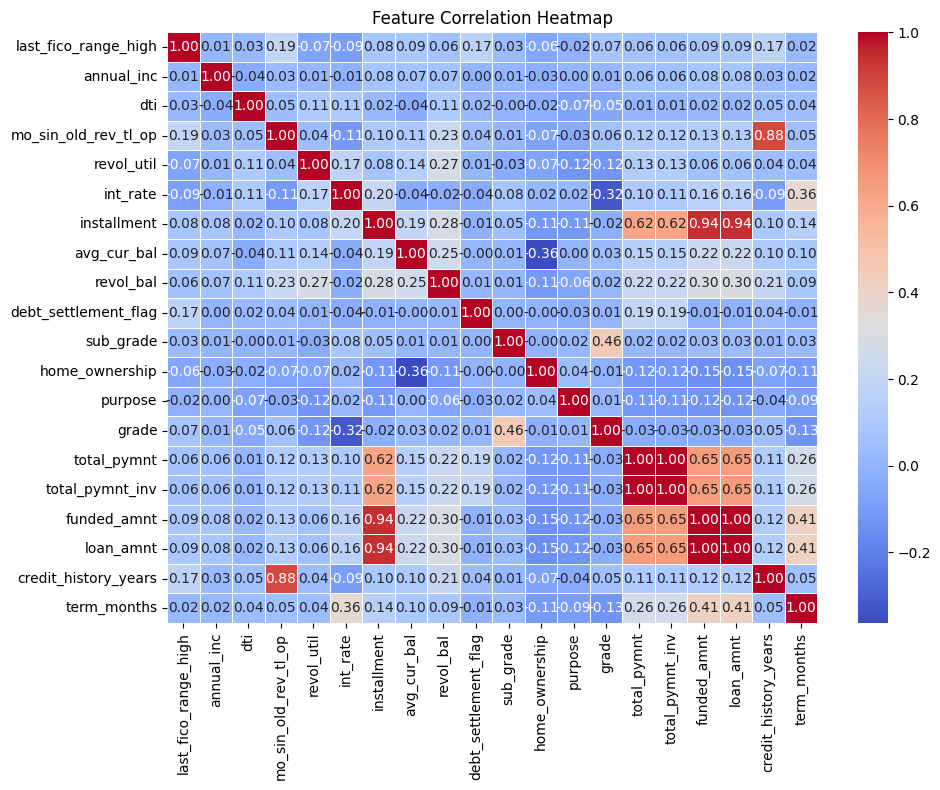

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = label1_data.copy()

if 'loan_status' in df.columns:
    df = df.drop(columns=['loan_status'])

# 문자열 → 숫자 변환 (필요시)
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.factorize(df[col])[0]

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()

plt.savefig("correlation_heatmap.png", dpi=300)

plt.show()


In [28]:
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        zero_count = (data[col] == 0).sum()
        if zero_count > 0:
            print(f"🔴 Column '{col}' has {zero_count} zero values.")
        else:
            print(f"✅ Column '{col}' has no zero values.")
    else:
        print(f"ℹ️ Column '{col}' is not numeric, skipped.")


🔴 Column 'last_fico_range_high' has 125 zero values.
🔴 Column 'annual_inc' has 653 zero values.
🔴 Column 'dti' has 828 zero values.
✅ Column 'mo_sin_old_rev_tl_op' has no zero values.
🔴 Column 'revol_util' has 6553 zero values.
✅ Column 'int_rate' has no zero values.
✅ Column 'installment' has no zero values.
🔴 Column 'avg_cur_bal' has 424 zero values.
🔴 Column 'revol_bal' has 6200 zero values.
ℹ️ Column 'debt_settlement_flag' is not numeric, skipped.
ℹ️ Column 'sub_grade' is not numeric, skipped.
ℹ️ Column 'home_ownership' is not numeric, skipped.
ℹ️ Column 'purpose' is not numeric, skipped.
ℹ️ Column 'grade' is not numeric, skipped.
🔴 Column 'total_pymnt' has 837 zero values.
🔴 Column 'total_pymnt_inv' has 932 zero values.
✅ Column 'funded_amnt' has no zero values.
✅ Column 'loan_amnt' has no zero values.
✅ Column 'credit_history_years' has no zero values.
✅ Column 'term_months' has no zero values.
🔴 Column 'loan_status' has 898669 zero values.


In [29]:
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        negative_count = (data[col] < 0).sum()
        if negative_count > 0:
            print(f"🔴 Column '{col}' has {negative_count} negative values.")
        else:
            print(f"✅ Column '{col}' has no negative values.")
    else:
        print(f"ℹ️ Column '{col}' is not numeric, skipped.")


✅ Column 'last_fico_range_high' has no negative values.
✅ Column 'annual_inc' has no negative values.
✅ Column 'dti' has no negative values.
✅ Column 'mo_sin_old_rev_tl_op' has no negative values.
✅ Column 'revol_util' has no negative values.
✅ Column 'int_rate' has no negative values.
✅ Column 'installment' has no negative values.
✅ Column 'avg_cur_bal' has no negative values.
✅ Column 'revol_bal' has no negative values.
ℹ️ Column 'debt_settlement_flag' is not numeric, skipped.
ℹ️ Column 'sub_grade' is not numeric, skipped.
ℹ️ Column 'home_ownership' is not numeric, skipped.
ℹ️ Column 'purpose' is not numeric, skipped.
ℹ️ Column 'grade' is not numeric, skipped.
✅ Column 'total_pymnt' has no negative values.
✅ Column 'total_pymnt_inv' has no negative values.
✅ Column 'funded_amnt' has no negative values.
✅ Column 'loan_amnt' has no negative values.
✅ Column 'credit_history_years' has no negative values.
✅ Column 'term_months' has no negative values.
✅ Column 'loan_status' has no negati